In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import pydicom
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.spatial.distance import directed_hausdorff
import re
from pathlib import Path  # Import pathlib for path handling

In [16]:
# Configuration
BASE_SEGMENTATION_DIR = Path("datasets/segmentation/PROSTATEX")      # Directory containing segmentation masks
BASE_IMAGES_DIR = Path("datasets/segmentation2/PROSTATEX")          # Directory containing image slices

SEGMENTATION_FILENAME = "1-1.dcm"                                         # Segmentation mask filename per patient
IMAGE_FILENAME_PATTERN = r".*\.dcm$"                                      # Pattern to match image slices

IMG_HEIGHT, IMG_WIDTH = 256, 256                                          # Desired image height and width after resizing
TARGET_DEPTH = 16                                                # Fixed number of slices per volume
BATCH_SIZE = 2                                                           # Adjust based on GPU memory
EPOCHS = 100

In [17]:
def load_dicom_image(file_path):
    """
    Load a DICOM file and return the image array.
    
    Parameters:
    - file_path: Path to the DICOM file.
    
    Returns:
    - image: 2D numpy array of the image data.
    """
    try:
        dicom = pydicom.dcmread(file_path)
        image = dicom.pixel_array.astype(np.float32)
        # Rescale if necessary based on DICOM metadata
        if 'RescaleSlope' in dicom and 'RescaleIntercept' in dicom:
            slope = dicom.RescaleSlope
            intercept = dicom.RescaleIntercept
            image = image * slope + intercept
        return image
    except Exception as e:
        print(f"Error loading DICOM file {file_path}: {e}")
        return None

def denoise_image(image):
    """
    Apply Non-Local Means denoising to the image.
    
    Parameters:
    - image: 2D numpy array.
    
    Returns:
    - denoised_image: 2D numpy array.
    """
    # Estimate the noise standard deviation from the noisy image
    sigma_est = np.mean(estimate_sigma(image, multichannel=False))
    denoised_image = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True,
                                     patch_size=5, patch_distance=3, multichannel=False)
    return denoised_image

def normalize_image(image, method='z-score'):
    """
    Normalize the image using the specified method.
    
    Parameters:
    - image: 2D numpy array.
    - method: 'z-score' or 'minmax'.
    
    Returns:
    - normalized_image: 2D numpy array.
    """
    if method == 'z-score':
        mean = np.mean(image)
        std = np.std(image)
        normalized_image = (image - mean) / (std + 1e-8)
    elif method == 'minmax':
        min_val = np.min(image)
        max_val = np.max(image)
        normalized_image = (image - min_val) / (max_val - min_val + 1e-8)
    else:
        raise ValueError("Unknown normalization method")
    return normalized_image

In [18]:
def resample_volume(volume, target_depth, is_mask=False):
    """
    Resample a 3D volume to have a fixed number of slices (depth).
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - target_depth: Desired number of slices.
    - is_mask: Boolean indicating if the volume is a mask (affects interpolation order).
    
    Returns:
    - resampled_volume: 3D numpy array with shape (target_depth, height, width).
    """
    current_depth = volume.shape[0]
    if current_depth == target_depth:
        return volume  # No resampling needed
    
    if is_mask:
        # Use nearest-neighbor interpolation for masks
        order = 0
    else:
        # Use linear interpolation for images
        order = 1
    
    # Calculate the new indices
    indices = np.linspace(0, current_depth - 1, target_depth)
    resampled_volume = []
    for i in range(volume.shape[1]):  # Iterate over height
        for j in range(volume.shape[2]):  # Iterate over width
            slice_1d = volume[:, i, j]
            resampled_slice = np.interp(indices, np.arange(current_depth), slice_1d)
            resampled_volume.append(resampled_slice)
    
    resampled_volume = np.array(resampled_volume).reshape(target_depth, volume.shape[1], volume.shape[2])
    return resampled_volume

In [19]:
def random_flip_3d(volume, mask):
    """
    Randomly flip the volume and mask along the horizontal and/or vertical axes.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    
    Returns:
    - volume_flipped: 3D numpy array.
    - mask_flipped: 3D numpy array.
    """
    # Flip along the width axis (axis=2)
    if np.random.rand() < 0.5:
        volume = np.flip(volume, axis=2)
        mask = np.flip(mask, axis=2)
    
    # Flip along the height axis (axis=1)
    if np.random.rand() < 0.5:
        volume = np.flip(volume, axis=1)
        mask = np.flip(mask, axis=1)
    
    return volume, mask

def random_rotate_3d(volume, mask):
    """
    Randomly rotate the volume and mask by 90 degrees around the depth axis.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    
    Returns:
    - volume_rotated: 3D numpy array.
    - mask_rotated: 3D numpy array.
    """
    k = np.random.choice([0, 1, 2, 3])
    volume = np.rot90(volume, k, axes=(1, 2))
    mask = np.rot90(mask, k, axes=(1, 2))
    return volume, mask

def random_scale_3d(volume, mask, scale_range=(0.9, 1.1)):
    """
    Randomly scale the volume and mask along the depth axis.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    - scale_range: Tuple indicating the scaling factor range.
    
    Returns:
    - volume_scaled: 3D numpy array.
    - mask_scaled: 3D numpy array.
    """
    current_depth = volume.shape[0]
    target_depth = TARGET_DEPTH
    if current_depth == target_depth:
        return volume, mask  # No scaling needed
    
    # Resample using the resample_volume function
    volume = resample_volume(volume, target_depth, is_mask=False)
    mask = resample_volume(mask, target_depth, is_mask=True)
    
    return volume, mask

def augment_data_3d(volume, mask):
    """
    Apply a series of random 3D augmentations to the volume and mask.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    
    Returns:
    - volume_augmented: 3D numpy array.
    - mask_augmented: 3D numpy array.
    """
    volume, mask = random_flip_3d(volume, mask)
    volume, mask = random_rotate_3d(volume, mask)
    volume, mask = random_scale_3d(volume, mask)
    return volume, mask

In [20]:
def load_dataset(segmentation_dir, images_dir, segmentation_filename, img_height, img_width, target_depth):
    """
    Load images and masks from separate directories, preprocess them, resample to fixed depth, and return as numpy arrays.
    
    Parameters:
    - segmentation_dir: Directory containing segmentation masks.
    - images_dir: Directory containing image slices.
    - segmentation_filename: Filename of the segmentation mask per patient.
    - img_height: Desired image height after resizing.
    - img_width: Desired image width after resizing.
    - target_depth: Fixed number of slices per volume.
    
    Returns:
    - images: Numpy array of preprocessed image volumes.
    - masks: Numpy array of corresponding segmentation masks.
    """
    number_of_images = 0
    
    images = []
    masks = []
    
    # Compile regex pattern for image filenames
    image_pattern = re.compile(IMAGE_FILENAME_PATTERN)
    
    # List of patients based on segmentation directory
    patients = [p for p in segmentation_dir.iterdir() if p.is_dir()]

    print(f"Found {len(patients)} patients")
    
    for patient_dir in patients:
        patient = patient_dir.name
        mask_path = patient_dir / segmentation_filename
        if not mask_path.exists():
            print(f"Segmentation mask not found for patient: {patient}")
            continue
        
        # Load segmentation mask
        mask_volume = load_dicom_image(mask_path)
        if mask_volume is None:
            print(f"Failed to load mask for patient: {patient}")
            continue
        
        # Check if mask_volume is 3D; if not, expand dimensions
        if len(mask_volume.shape) == 2:
            mask_volume = np.expand_dims(mask_volume, axis=0)  # Shape: (depth=1, height, width)

        # Display the masks
        plt.figure(figsize=(12, 4))
        plt.imshow(mask_volume[0], cmap='gray')
        plt.axis('off')
        plt.title(f"Patient {patient}: Segmentation Mask")
        plt.show()
        
        
        # Path to image slices
        patient_img_dir = images_dir / patient
        if not patient_img_dir.exists():
            print(f"Image directory not found for patient: {patient}")
            continue
        
        # List all DICOM files in image directory matching the pattern
        img_files = sorted([f for f in patient_img_dir.iterdir() if f.is_file() and image_pattern.match(f.name)])
        if len(img_files) == 0:
            print(f"No image slices found for patient: {patient}")
            continue
        
        # Load each slice
        img_slices = []
        for img_file in img_files:
            img_slice = load_dicom_image(img_file)
            if img_slice is None:
                print(f"Failed to load image slice: {img_file}")
                break
            img_slices.append(img_slice)
        
        if len(img_slices) == 0:
            print(f"No valid image slices loaded for patient: {patient}")
            continue
        
#        if number_of_images < 5:
#          # Let's say we only show the first 3 slices of this patient for clarity
#          num_slices_to_show = min(3, len(img_slices))
#
#          plt.figure(figsize=(12, num_slices_to_show * 4))  # Adjust figure size accordingly
#
#          for i in range(num_slices_to_show):
#              slice_img = img_slices[i]
#              # Find corresponding mask slice.
#              # Since we haven't resized yet or done augment_data_3d at this point,
#              # assume mask_volume and img_slices align in depth.
#              # If they differ, you'll need to handle that carefully.
#
#              # Check if mask_volume has at least i-th slice
#              if i < mask_volume.shape[0]:
#                  slice_mask = mask_volume[i]
#              else:
#                  slice_mask = np.zeros_like(slice_img)
#
#              # Show image slice
#              plt.subplot(num_slices_to_show, 2, 2*i + 1)
#              plt.imshow(slice_img, cmap='gray')
#              plt.axis('off')
#              plt.title(f"Patient {patient}: Slice {i} Image")
#
#              # Show mask slice
#              plt.subplot(num_slices_to_show, 2, 2*i + 2)
#              plt.imshow(slice_mask, cmap='gray')
#              plt.axis('off')
#              plt.title(f"Patient {patient}: Slice {i} Mask")
#
#          plt.tight_layout()
#          plt.show()
#          number_of_images += 1
        
        # Stack slices to form a 3D volume
        img_volume = np.stack(img_slices, axis=0)  # Shape: (depth, height, width)
        
        # Resample image and mask to fixed depth
        img_volume, mask_volume = augment_data_3d(img_volume, mask_volume)
        
        # Preprocessing: Denoising and Normalization
        # Already applied in augment_data_3d function
        
        # Resize each slice to desired dimensions
        img_volume_resized = []
        mask_volume_resized = []
        for slice_img, slice_mask in zip(img_volume, mask_volume):
            slice_img = cv2.resize(slice_img, (img_width, img_height), interpolation=cv2.INTER_LINEAR)
            slice_mask = cv2.resize(slice_mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            img_volume_resized.append(slice_img)
            mask_volume_resized.append(slice_mask)
        
        img_volume_resized = np.array(img_volume_resized)
        mask_volume_resized = np.array(mask_volume_resized)
        
        # Ensure masks are binary
        mask_volume_resized = (mask_volume_resized > 0.5).astype(np.uint8)
        
        images.append(img_volume_resized)
        masks.append(mask_volume_resized)

        print(f"Processed patient: {patient}")
    
    images = np.array(images)  # Shape: (num_patients, depth, height, width)
    masks = np.array(masks)    # Shape: (num_patients, depth, height, width)
    
    return images, masks

In [ ]:
import os
import subprocess
!pip install SimpleITK
import SimpleITK as sitk

def load_images_with_segmentation(dicom_image_dir, dicom_seg_path, output_dir):
    """
    Load image and segmentation using dcmqi and SimpleITK.
    
    Parameters:
    - dicom_image_dir: Directory containing the DICOM image slices for one patient.
    - dicom_seg_path: Path to the DICOM SEG file (segmentation).
    - output_dir: Temporary directory to store the converted NRRD segmentation.
    
    Returns:
    - image: A SimpleITK image representing the original volume.
    - seg: A SimpleITK image representing the segmentation mask.
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Convert the DICOM SEG to NRRD using segimage2itkimage from dcmqi
    # This will create a NRRD file and a JSON metadata file in the output directory.
    cmd = [
        "segimage2itkimage",
        "--inputDICOM", dicom_seg_path,
        "--outputDirectory", output_dir,
        "--outputType", "nrrd"  # You can choose nrrd or nii.gz
    ]
    
    # Run the dcmqi command
    subprocess.run(cmd, check=True)

    # The segimage2itkimage tool by default creates a file called "itkimage.nrrd"
    # and "itkimage.json" in the output directory. The NRRD is the segmentation image.
    seg_nrrd_path = os.path.join(output_dir, "itkimage.nrrd")

    if not os.path.exists(seg_nrrd_path):
        raise FileNotFoundError("Failed to create segmentation NRRD file.")
    
    # 2. Load the segmentation as a SimpleITK image
    seg = sitk.ReadImage(seg_nrrd_path)
    
    # 3. Load the DICOM series for the original images
    # Identify the DICOM series in the directory
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(dicom_image_dir)
    if len(dicom_series) == 0:
        raise FileNotFoundError(f"No DICOM series found in {dicom_image_dir}")
    
    reader.SetFileNames(dicom_series)
    image = reader.Execute()
    
    # image: a SimpleITK image with original volume data
    # seg: a SimpleITK image with segmentation mask
    
    return image, seg

# Example usage:
# Assume we have:
dicom_image_dir = "path/to/dicom_images"
dicom_seg_path = "path/to/segmentation.dcm"
output_dir = "path/to/temp_output"
image, seg = load_images_with_segmentation(dicom_image_dir, dicom_seg_path, output_dir)

# Now you can convert them to numpy arrays if needed:
image_array = sitk.GetArrayFromImage(image)  # shape: (depth, height, width)
seg_array = sitk.GetArrayFromImage(seg)      # shape: (depth, height, width)

# seg_array is typically binary or label map depending on the SEG structure.

In [21]:
# Load the dataset
images, masks = load_dataset(
    segmentation_dir=BASE_SEGMENTATION_DIR,
    images_dir=BASE_IMAGES_DIR,
    segmentation_filename=SEGMENTATION_FILENAME,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    target_depth=TARGET_DEPTH
)

print(f"Loaded {images.shape[0]} patients.")
print(f"Image shape: {images.shape}")  # Expected: (num_patients, depth=19, height=256, width=256)
print(f"Mask shape: {masks.shape}")    # Expected: (num_patients, depth=19, height=256, width=256)")

Found 66 patients
Processed patient: ProstateX-0004
Processed patient: ProstateX-0007
Processed patient: ProstateX-0009
Processed patient: ProstateX-0015
Processed patient: ProstateX-0020
Processed patient: ProstateX-0026
Processed patient: ProstateX-0046
Processed patient: ProstateX-0054
Processed patient: ProstateX-0056
Processed patient: ProstateX-0065
Processed patient: ProstateX-0066
Processed patient: ProstateX-0069
Processed patient: ProstateX-0070
Processed patient: ProstateX-0072
Processed patient: ProstateX-0076
Processed patient: ProstateX-0083
Processed patient: ProstateX-0084
Processed patient: ProstateX-0089
Processed patient: ProstateX-0090
Processed patient: ProstateX-0094
Processed patient: ProstateX-0096
Processed patient: ProstateX-0102
Processed patient: ProstateX-0111
Processed patient: ProstateX-0112
Processed patient: ProstateX-0117
Processed patient: ProstateX-0118
Processed patient: ProstateX-0121
Processed patient: ProstateX-0125
Processed patient: ProstateX-0

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (52, 16, 256, 256), (52, 16, 256, 256)
Validation set: (14, 16, 256, 256), (14, 16, 256, 256)


In [25]:
def data_generator_3d(X, Y, batch_size, img_height, img_width, target_depth):
    """
    Generate batches of augmented 3D data.
    
    Parameters:
    - X: Numpy array of image volumes (num_patients, depth, height, width).
    - Y: Numpy array of mask volumes (num_patients, depth, height, width).
    - batch_size: Number of samples per batch.
    - img_height: Image height.
    - img_width: Image width.
    - target_depth: Fixed number of slices per volume.
    
    Yields:
    - Batch of images and masks with shape (batch_size, depth, height, width, 1).
    """
    num_samples = X.shape[0]
    while True:
        idxs = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_idxs = idxs[i:i + batch_size]
            batch_imgs = []
            batch_masks = []
            for idx in batch_idxs:
                img, mask = X[idx], Y[idx]
                img, mask = augment_data_3d(img, mask)
                img = np.expand_dims(img, axis=-1)  # Shape: (depth, height, width, 1)
                mask = np.expand_dims(mask, axis=-1)  # Shape: (depth, height, width, 1)
                batch_imgs.append(img)
                batch_masks.append(mask)
            yield np.array(batch_imgs), np.array(batch_masks)

# Create generators
train_gen = data_generator_3d(
    X_train, y_train, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, TARGET_DEPTH
)
val_gen = data_generator_3d(
    X_val, y_val, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, TARGET_DEPTH
)

In [26]:
# Import Optimizer
from tensorflow.keras.optimizers import Adam

def conv_block_3d(x, filters):
    x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_3d_unet(input_shape=(TARGET_DEPTH, IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    c1 = conv_block_3d(inputs, 32)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    
    c2 = conv_block_3d(p1, 64)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)
    
    c3 = conv_block_3d(p2, 128)
    p3 = layers.MaxPooling3D((2, 2, 2))(c3)
    
    # Bottleneck
    c4 = conv_block_3d(p3, 256)
    
    # Decoder
    u5 = layers.Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = conv_block_3d(u5, 128)
    
    u6 = layers.Conv3DTranspose(64, (2,2,2), strides=(2,2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = conv_block_3d(u6, 64)
    
    u7 = layers.Conv3DTranspose(32, (2,2,2), strides=(2,2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = conv_block_3d(u7, 32)
    
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c7)
    model = keras.Model(inputs, outputs)
    return model

# Build the model
model = build_3d_unet()
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 16, 256, 256  896         ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 16, 256, 256  27680       ['conv3d[0][0]']                 
                                , 32)                                                         

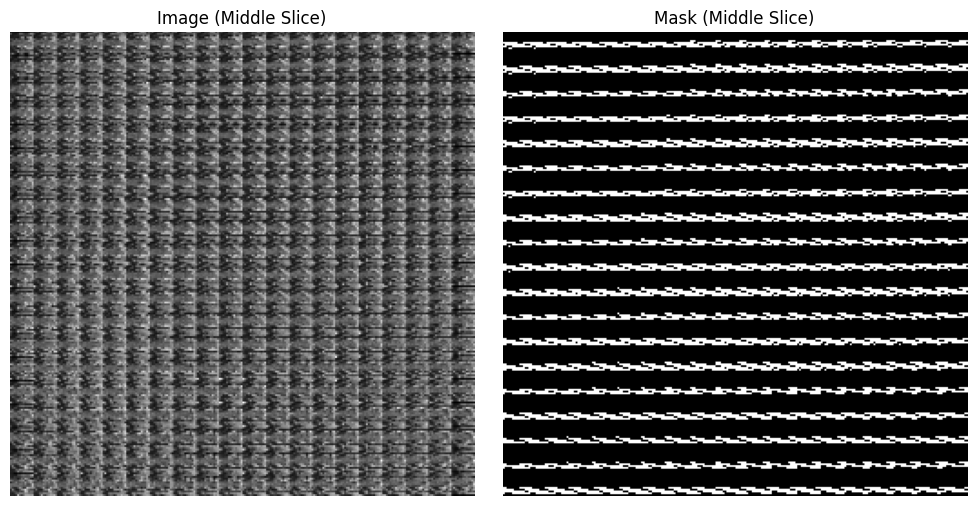

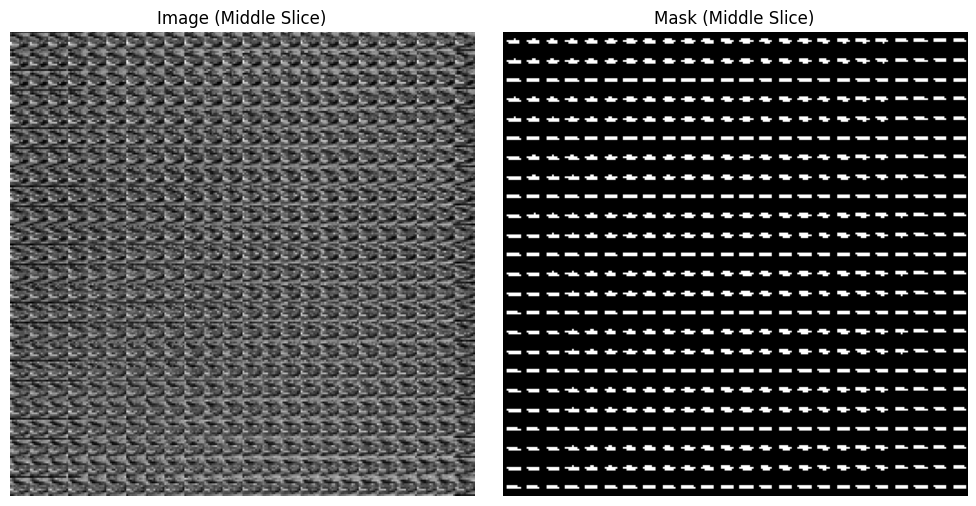

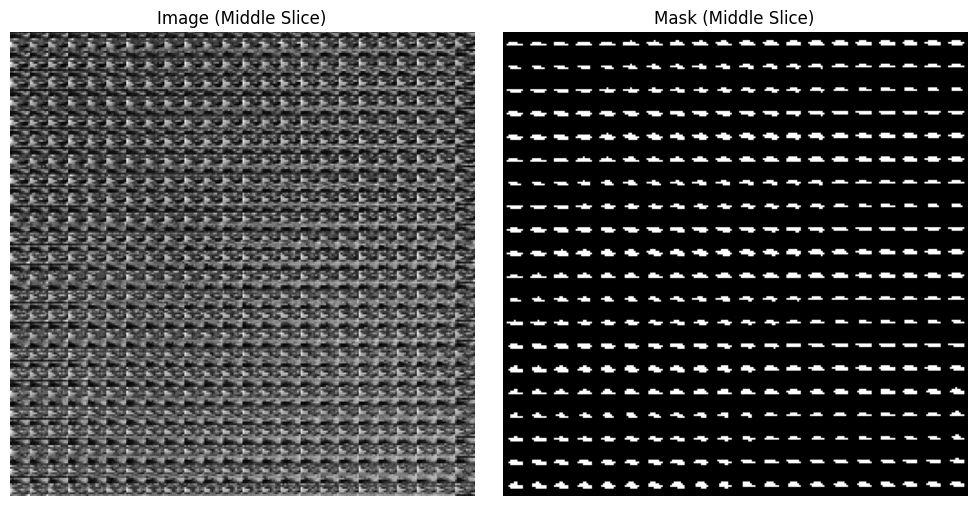

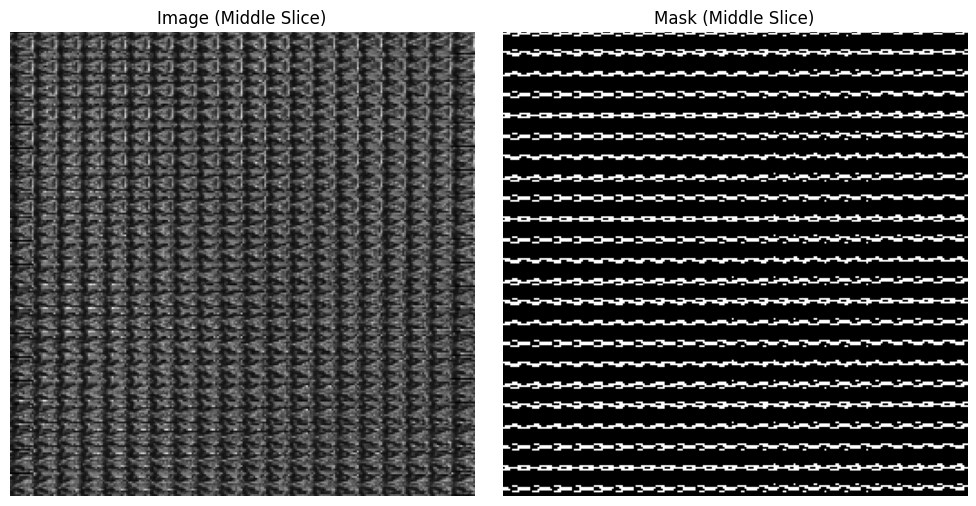

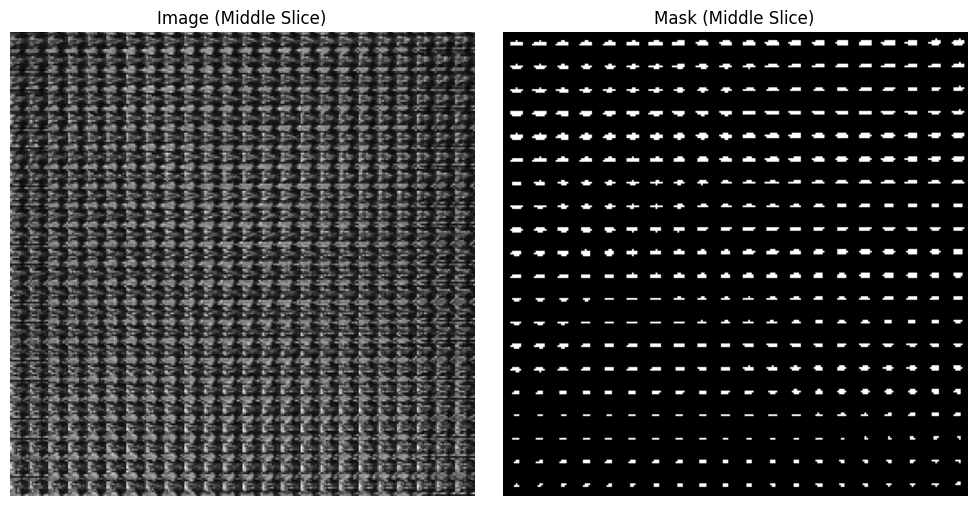

In [27]:
# Visually inspect the Ground Truth images and masks
def plot_images(images, masks, num_images=5):
    for i in range(num_images):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        mask = masks[idx]
        mid_slice = img.shape[0] // 2  # Select the middle slice
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img[mid_slice], cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Image (Middle Slice)')
        ax[1].imshow(mask[mid_slice], cmap='gray')
        ax[1].axis('off')
        ax[1].set_title('Mask (Middle Slice)')
        plt.tight_layout()
        plt.show()

plot_images(X_train, y_train)

In [28]:
# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "prostate_segmentation_best.keras", 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.9572
Epoch 1: val_loss improved from inf to 0.19287, saving model to prostate_segmentation_best.keras
26/26 [==============================] - 183s 3s/step - loss: 0.3462 - accuracy: 0.9572 - val_loss: 0.1929 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9665
Epoch 2: val_loss improved from 0.19287 to 0.12962, saving model to prostate_segmentation_best.keras
26/26 [==============================] - 84s 3s/step - loss: 0.1537 - accuracy: 0.9665 - val_loss: 0.1296 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9689
Epoch 3: val_loss improved from 0.12962 to 0.11702, saving model to prostate_segmentation_best.keras
26/26 [==============================] - 84s 3s/step - loss: 0.1222 - accuracy: 0.9689 - val_loss: 0.1170 - val_accuracy: 0.96

In [29]:
def dice_coefficient_np(y_true, y_pred):
    """
    Compute Dice Similarity Coefficient.
    
    Parameters:
    - y_true: Ground truth mask (3D numpy array).
    - y_pred: Predicted mask (3D numpy array).
    
    Returns:
    - Dice coefficient.
    """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-8)

def hausdorff_distance_np(y_true, y_pred):
    """
    Compute Hausdorff Distance between two binary masks.
    
    Parameters:
    - y_true: Ground truth mask (3D numpy array).
    - y_pred: Predicted mask (3D numpy array).
    
    Returns:
    - Hausdorff distance.
    """
    y_true_pts = np.argwhere(y_true)
    y_pred_pts = np.argwhere(y_pred)
    
    if len(y_true_pts) == 0 or len(y_pred_pts) == 0:
        return np.inf
    
    forward_hd = directed_hausdorff(y_true_pts, y_pred_pts)[0]
    backward_hd = directed_hausdorff(y_pred_pts, y_true_pts)[0]
    
    return max(forward_hd, backward_hd)

7/7 [==============================] - 7s 1s/step
Prediction stats:
Min: 2.2193172e-22
Max: 0.92145526
Mean: 0.023075089
Std: 0.057109244
Mean Dice Coefficient on Validation Set: 0.0192
Mean Hausdorff Distance on Validation Set: 46.9242 mm


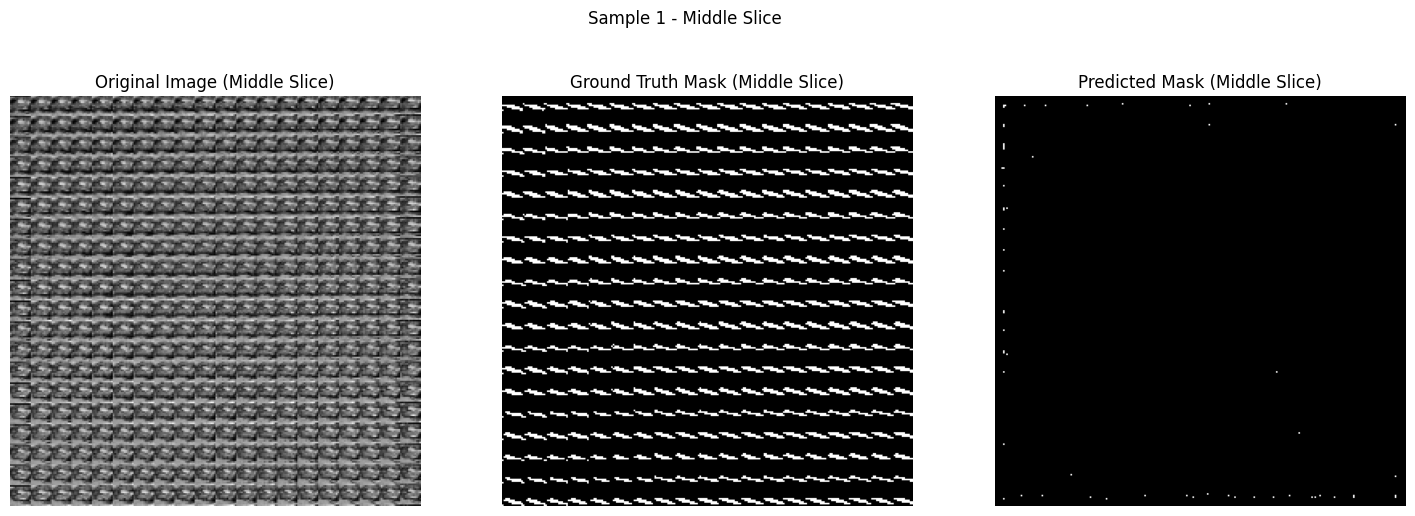

In [30]:
from tensorflow.keras.models import load_model

def visualize_prediction_3d(image_volume, ground_truth_volume, prediction_volume, idx):
    """
    Display the middle slice of the 3D volume: original image, ground truth mask, and predicted mask.
    
    Parameters:
    - image_volume: 3D numpy array (depth, height, width).
    - ground_truth_volume: 3D numpy array (depth, height, width).
    - prediction_volume: 3D numpy array (depth, height, width).
    - idx: Index of the sample.
    """
    mid_slice = TARGET_DEPTH // 2
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_volume[mid_slice], cmap='gray')
    plt.title('Original Image (Middle Slice)')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_volume[mid_slice], cmap='gray')
    plt.title('Ground Truth Mask (Middle Slice)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction_volume[mid_slice], cmap='gray')
    plt.title('Predicted Mask (Middle Slice)')
    plt.axis('off')
    
    plt.suptitle(f"Sample {idx} - Middle Slice")
    plt.show()

# Load the entire model (ensure the filename matches how you saved it)
model = load_model("prostate_segmentation_best.keras")

# Predict on the validation set with reduced batch size to prevent OOM
val_predictions = model.predict(X_val, batch_size=2)

# Check prediction statistics
print("Prediction stats:")
print("Min:", np.min(val_predictions))
print("Max:", np.max(val_predictions))
print("Mean:", np.mean(val_predictions))
print("Std:", np.std(val_predictions))

# Binarize predictions with threshold=0.5
val_predictions_bin = (val_predictions > 0.5).astype(np.uint8)

# Compute metrics
dice_scores = []
hausdorff_scores = []

for i in range(len(y_val)):
    dice = dice_coefficient_np(y_val[i], val_predictions_bin[i, :, :, :, 0])
    hd = hausdorff_distance_np(y_val[i], val_predictions_bin[i, :, :, :, 0])
    dice_scores.append(dice)
    hausdorff_scores.append(hd)

print(f"Mean Dice Coefficient on Validation Set: {np.mean(dice_scores):.4f}")
print(f"Mean Hausdorff Distance on Validation Set: {np.mean(hausdorff_scores):.4f} mm")

# Visualize the first validation sample
visualize_prediction_3d(
    X_val[0],
    y_val[0],
    val_predictions_bin[0, :, :, :, 0],
    idx=1
)

In [33]:
# Check if there are any positive labels in the first validation mask
print("Sum of ground truth mask:", np.sum(y_val[0]))


Sum of ground truth mask: 38549


In [32]:
# Save the model
model.save("prostate_segmentation.keras")
print("Model saved as prostate_segmentation.keras")

Model saved as prostate_segmentation.keras


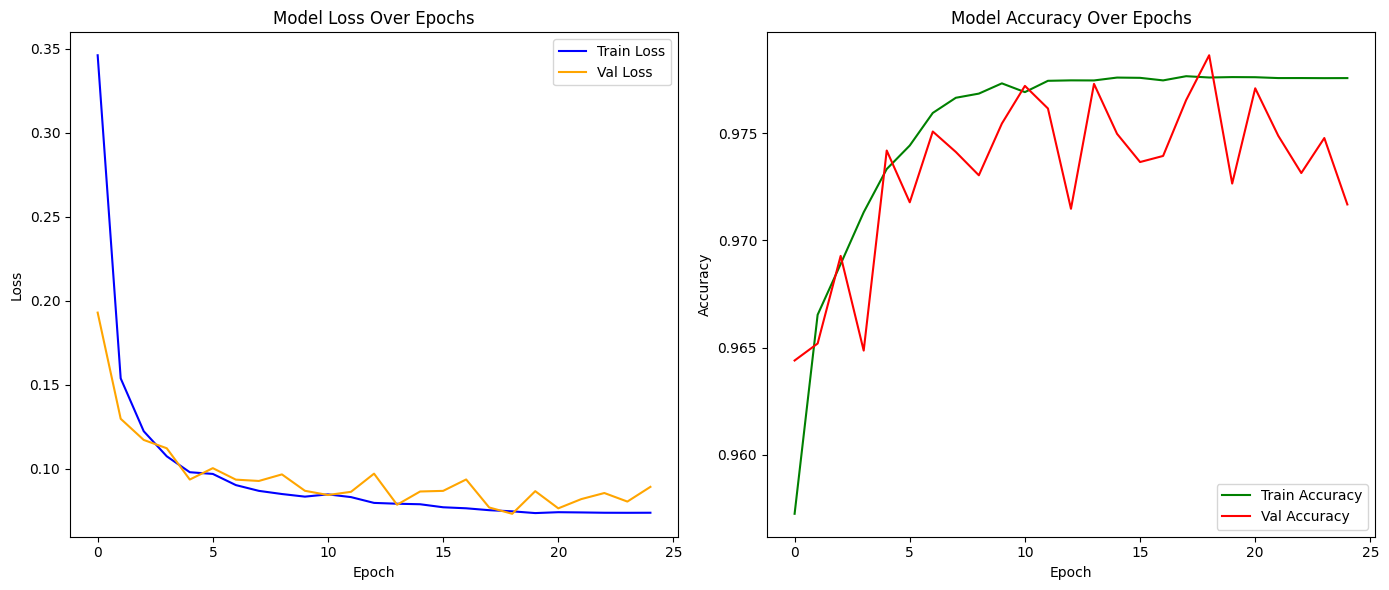

In [31]:
# Plot training & validation loss and accuracy values
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()